# **This notebook handles the EDA**

## Objectives

* In this notebook we will perform exploratory data analysis (EDA) on the dataset to understand its structure, identify patterns, and uncover insights that will inform subsequent analysis and modeling steps.
* It will be done in 2 phases:
    1. Descriptive EDA: This phase involves summarizing the main characteristics of the dataset. We will also visualize the data using charts and graphs to identify trends and patterns.
    2. Hypothesis-Driven EDA: In this phase, we will formulate specific hypotheses based on initial observations and test them using statistical methods. This will help us validate or refute our assumptions about the data.

## Inputs

* The input data will be the cleaned_diabetes_data.csv file generated from the ETL notebook.

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\nived\\Desktop\\Nivya work learnings\\data analytics_ai\\Capstone\\Healthcare_Diabetes_Analysis\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\nived\\Desktop\\Nivya work learnings\\data analytics_ai\\Capstone\\Healthcare_Diabetes_Analysis'

# Phase 1: Descriptive EDA

Here we will be performing descriptive EDA on the dataset to summarize its main characteristics and visualize the data to identify trends and patterns.

* Import necessary libraries

In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pingouin as pg
from scipy.stats import mannwhitneyu

* Load the clean dataset and display the first few rows

In [6]:
df = pd.read_csv('Data/cleaned/cleaned_diabetes_data.csv')
df.head()

gender  age  hypertension  heart_disease smoking_history    bmi  \
0    Male   80             0              0          former  26.40   
1  Female   47             0              0           never  45.88   
2  Female   26             0              0     not current  27.32   
3    Male   80             0              0         No Info  27.32   
4    Male   57             0              0         No Info  27.32   

   HbA1c_level  blood_glucose_level  diabetes  
0          8.2                  126         1  
1          4.0                  159         0  
2          6.0                  130         0  
3          7.5                  160         1  
4          5.8                  158         0

* inspect the dataset for data types, missing values, and basic statistics

In [7]:
# using info() to get a concise summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9042 entries, 0 to 9041
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               9042 non-null   object 
 1   age                  9042 non-null   int64  
 2   hypertension         9042 non-null   int64  
 3   heart_disease        9042 non-null   int64  
 4   smoking_history      9042 non-null   object 
 5   bmi                  9042 non-null   float64
 6   HbA1c_level          9042 non-null   float64
 7   blood_glucose_level  9042 non-null   int64  
 8   diabetes             9042 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 635.9+ KB


    -  No null values, and all columns have appropriate data types.

* check for count of missing values (Nan / None values) in each column

In [8]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

    -  No missing values found

* checking for duplicates

In [9]:
df.duplicated().sum()

0

    - no duplicates found

* Checking the statistical summary of numerical columns using describe()

In [10]:
df.describe().T

count        mean        std    min       25%      50%  \
age                  9042.0   54.966158  17.211084  18.00   42.0000   57.000   
hypertension         9042.0    0.164455   0.370708   0.00    0.0000    0.000   
heart_disease        9042.0    0.095665   0.294147   0.00    0.0000    0.000   
bmi                  9042.0   30.372424   7.090530  10.98   27.0625   27.535   
HbA1c_level          9042.0    6.243696   1.295101   3.50    5.7000    6.100   
blood_glucose_level  9042.0  166.425680  57.781870  80.00  130.0000  155.000   
diabetes             9042.0    0.547003   0.497813   0.00    0.0000    1.000   

                          75%     max  
age                   69.0000   80.00  
hypertension           0.0000    1.00  
heart_disease          0.0000    1.00  
bmi                   33.4775   88.72  
HbA1c_level            6.8000    9.00  
blood_glucose_level  200.0000  300.00  
diabetes               1.0000    1.00

* The describe() function provides a summary of statistics for numerical columns, including count, mean, standard deviation, minimum, maximum, and quartiles. Below is the desciption for few statistical terms used in the summary:

  -  Mean: The mean is the average value of a dataset, indicating its central tendency.

  -  Median: The median is the middle value that separates the higher half from the lower half of a dataset.

  -  Standard Deviation: Standard deviation measures how spread out the values in a dataset are around the mean.

  -  Hypothesis Testing: Hypothesis testing is a method to determine whether a result is statistically significant or due to random chance.

  -  Probability: Probability quantifies the likelihood of an event occurring within a defined set of outcomes.

* I would like to check if the max value of:
    -  9 for HbA1c_level is a valid value or an outlier.
    - 88.72 for BMI is a valid value or an outlier.
    - 300 for glucose level is a valid value or an outlier.

In [11]:
# using a custom function to check for outliers using the IQR method

def check_outlier_iqr(df, column, value):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return value < lower_bound or value > upper_bound

# applying the above funtion to columns HbA1c_level, BMI, and glucose_level

columns_to_check = ['HbA1c_level', 'bmi', 'blood_glucose_level']
values_to_check = [9, 88.72, 300]  # values to check for each column taken from max values in describe()

for col, val in zip(columns_to_check, values_to_check):
    result = check_outlier_iqr(df, col, val)
    print(f"Is {val} an outlier in {col}? → {result}")

Is 9 an outlier in HbA1c_level? → True
Is 88.72 an outlier in bmi? → True
Is 300 an outlier in blood_glucose_level? → False


    -  From the IQR we can see that the max values for HbA1c_level, BMI are outliers. will visualise them using plots and decide how to handle them.

* Target variable analysis - distribution of the target variable diabetes

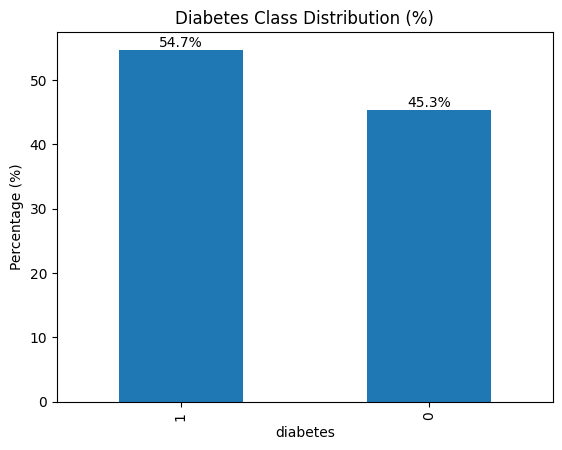

In [12]:
# calculating the percentage distribution of the target variable 'diabetes'

diabetes_class_percentages = df['diabetes'].value_counts(normalize=True)*100

# Plot as bar chart
ax = diabetes_class_percentages.plot(kind='bar', title='Diabetes Class Distribution (%)')

# Add percentage labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')

plt.ylabel('Percentage (%)')
plt.show()


    -  The target class is relatively balanced with 45.3% having no diabetes and 54.7% having diabetes.

*Note: For purpose of this project, the actual dataset has been modified to have a balanced target variable. Post cleaning this is the distribution of the target variable.*

* A basic histogram+KDE to visualize the distribution of the numerical features.
     - excluding target variable diabetes, numeric binary variables hypertension, heart_disease.

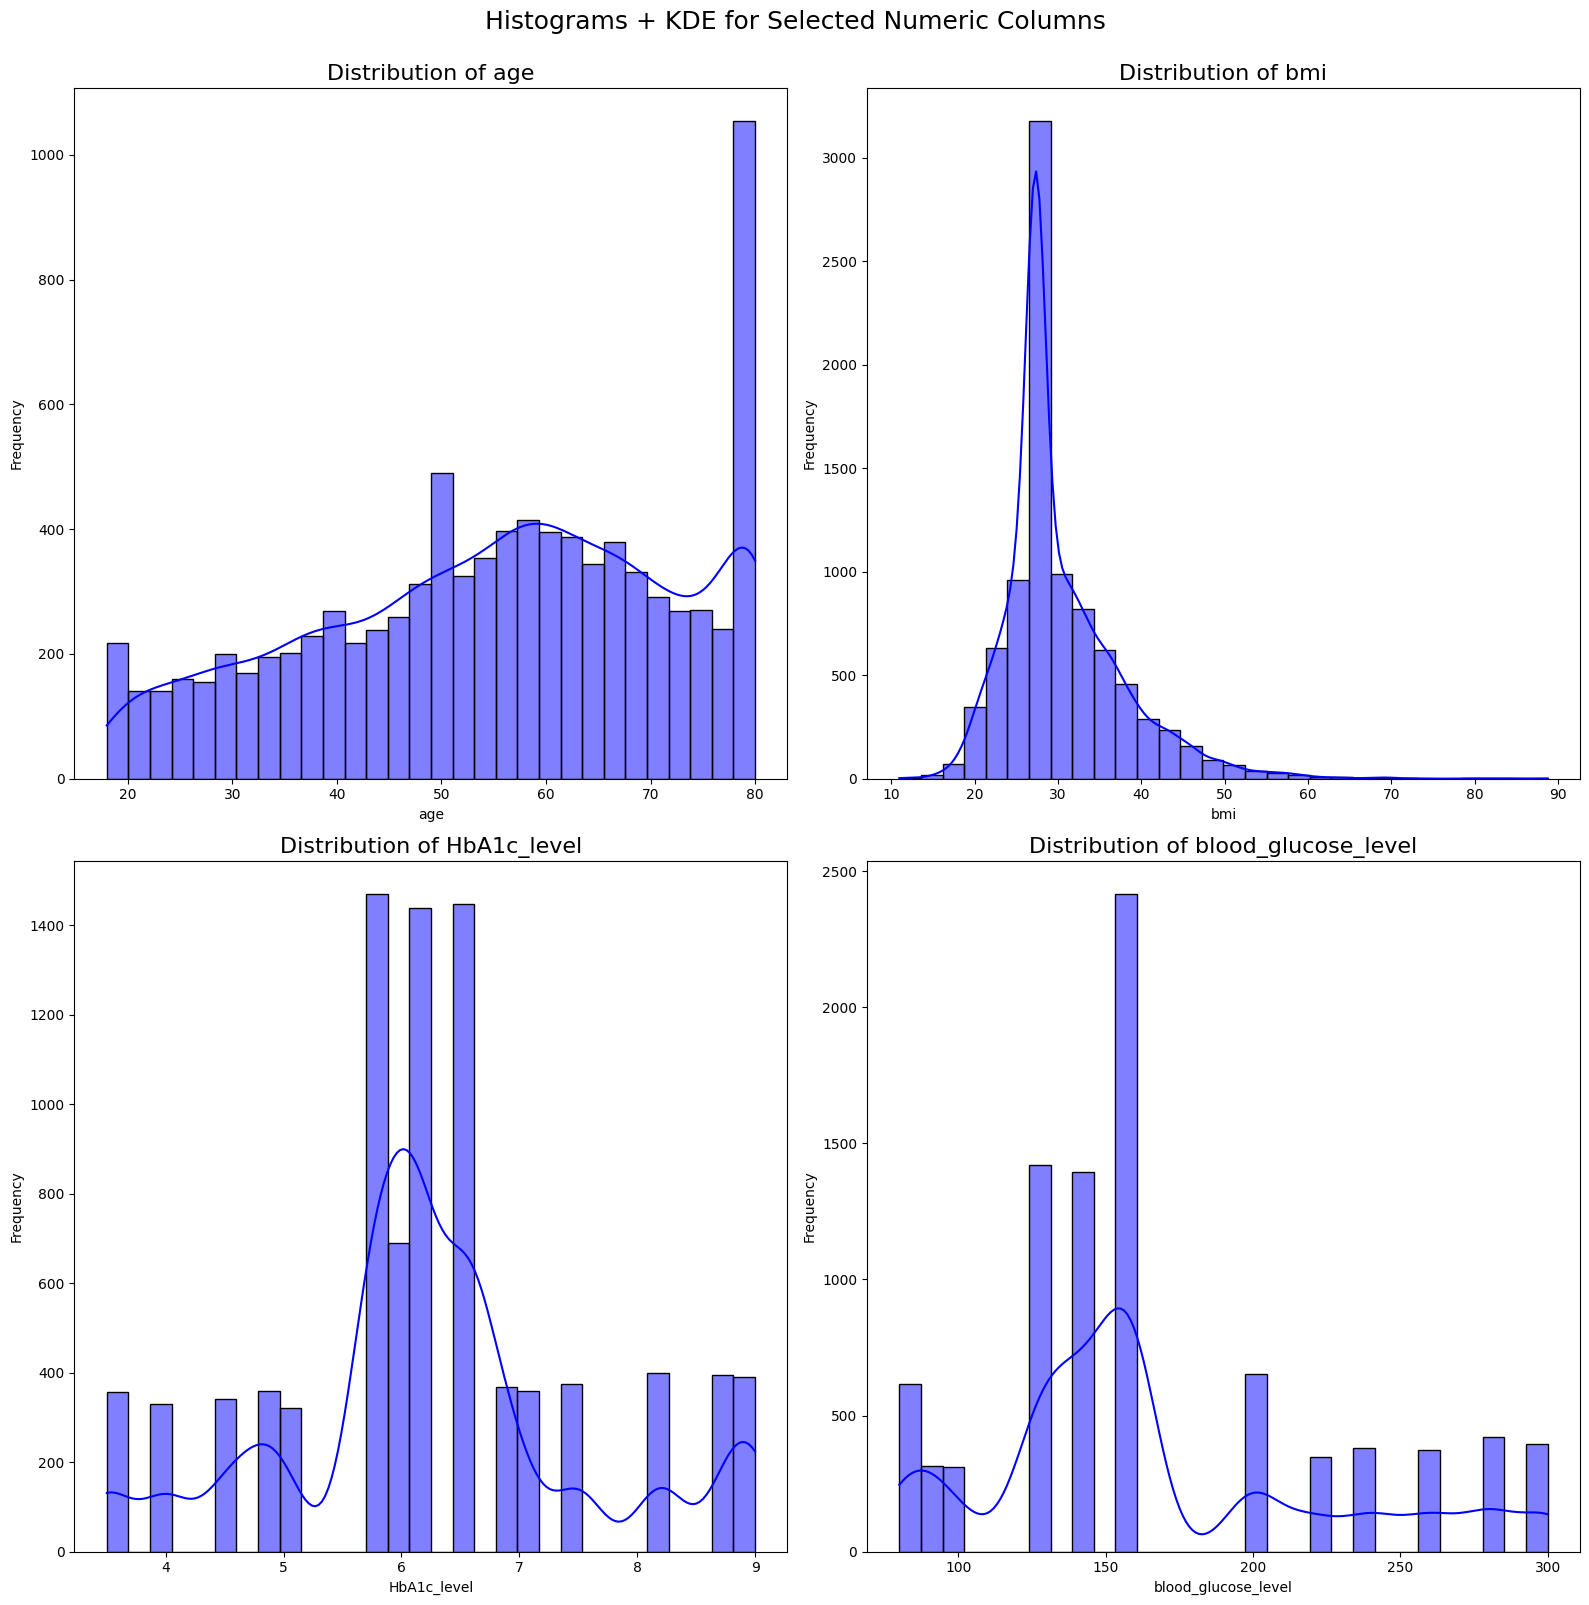

In [13]:
num_cols = ['age','bmi','HbA1c_level','blood_glucose_level']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
axes = axes.flatten()  # flatten to loop easily

for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i], color='blue', edgecolor='black')
    axes[i].set_title(f'Distribution of {col}', fontsize=16)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

fig.suptitle('Histograms + KDE for Selected Numeric Columns', fontsize=18,y=1) 
plt.tight_layout()
plt.show()

#### * Here's what we can say about the data distribution from above plots:

#### 1. Age

**Distribution Shape:** Right-skewed (positively skewed).

**Observations:**
- Frequencies increase with age, peaking at around 75–80.
- There’s a notable spike near 80.

**Inference:** Most of the patients are older adults, with a concentration in the 50–80 age range.

#### 2. BMI (Body Mass Index)

**Distribution Shape**: Right-skewed (positively skewed).

**Observations:**
- The mode (most common BMI) is around 28–30.
- Long tail towards higher BMI values.(this supports our earlier observation of outliers).
- Very few individuals have a BMI over 60.

**Inference:** The majority of individuals have BMI values in the overweight/obese range (25–35). Some outliers with very high BMI exist.

#### 3. HbA1c Level

**Distribution Shape:** Multimodal

**Observations:**
- Peaks around 6.0–6.5 and again around 8.0–8.5.

**Inference:** Indicates that many individuals are clustered around diabetic or prediabetic thresholds. Possibly influenced by clinical cutoffs (e.g., 6.5%).

#### 4. Blood Glucose Level

**Distribution Shape:** Multimodal with possible right skew.

**Observations:**
- A strong peak around 140–150.
- Secondary clusters at higher levels (200+).
- Wide spread with a long tail on the right.

**Inference:** Indicates a mixed population — possibly both diabetic and non-diabetic individuals. The high number of elevated glucose levels suggests a focus on patients at risk for or diagnosed with diabetes.

* Bar plots to visualize the distribution of numerical binary variables hypertension, heart_disease

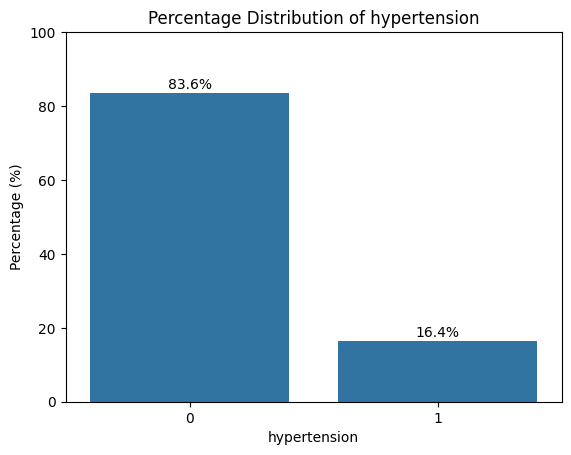

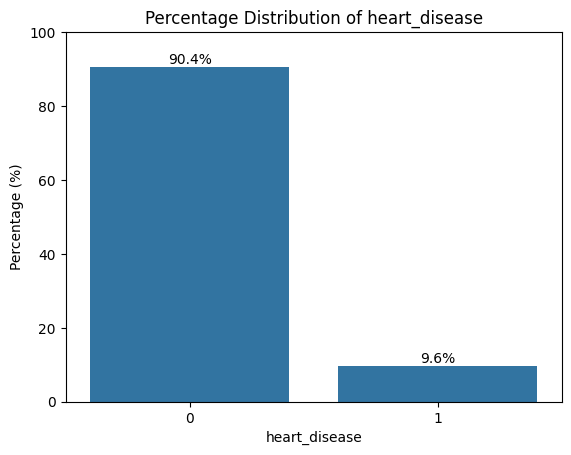

In [15]:
# calculating the percentage distribution of the variables 'hypertension' and 'heart_disease'

num_bin_cols = ['hypertension', 'heart_disease']

for col in num_bin_cols:
    val_counts = df[col].value_counts(normalize=True)*100

    # Plot as bar chart

    sns.barplot(x=val_counts.index, y=val_counts.values)
    
    plt.title(f'Percentage Distribution of {col}')
    plt.ylabel('Percentage (%)')
    plt.xlabel(col)
    plt.ylim(0, 100)  # For better scale

    # Show values on top of bars
    for i, val in enumerate(val_counts.values):
        plt.text(i, val + 1, f'{val:.1f}%', ha='center')
    
    plt.show()


    -  the above stats show majority of the patients do not have hypertension or heart disease. Only 9.6% have heart disease and 16.4% have hypertension.

* Plotting the categorical variables(gender, smoking_history) using count plots to visualize their distributions


C:\Users\nived\AppData\Local\Temp\ipykernel_6432\751489285.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gender', data=df, palette='pastel', ax=axes[0])
C:\Users\nived\AppData\Local\Temp\ipykernel_6432\751489285.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='smoking_history', data=df, palette='pastel', ax=axes[1])


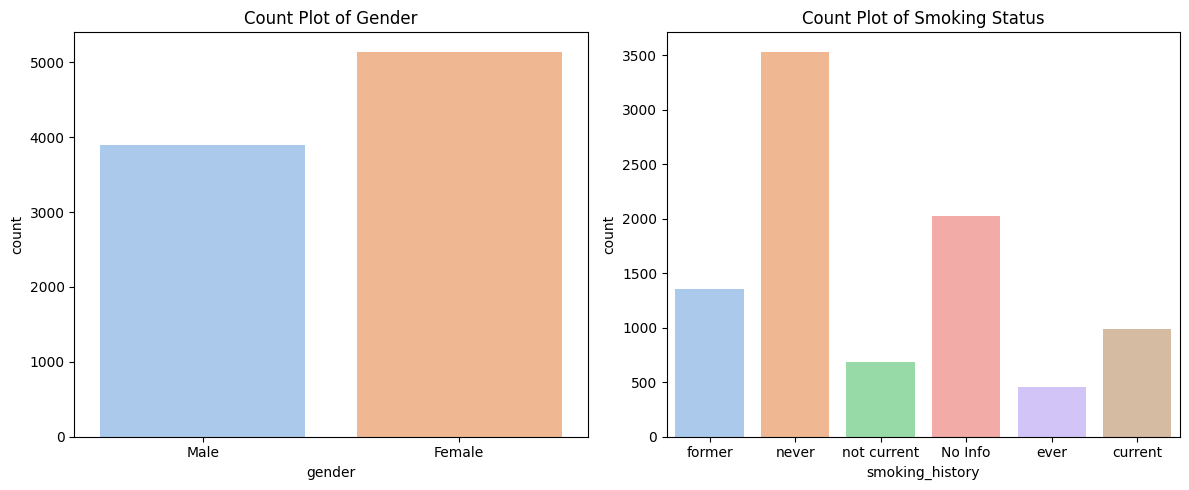

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 cols

sns.countplot(x='gender', data=df, palette='pastel', ax=axes[0])
axes[0].set_title('Count Plot of Gender')

sns.countplot(x='smoking_history', data=df, palette='pastel', ax=axes[1])
axes[1].set_title('Count Plot of Smoking Status')

plt.tight_layout()
plt.show()

    - we see that the dataset has a higher proportion of females and higher count of never smoked individuals.

---

### Bi-Variate analysis

* Plotting the continuous numeric variables against the target variable diabetes using box plots to visualize their distributions across the two classes of the target variable.

In [28]:
num_cols = ['bmi', 'age', 'blood_glucose_level', 'HbA1c_level']

for col in num_cols:
    fig = px.box(df, x='diabetes', y=col, points='all',
                 title=f'{col} by diabetes',
                 labels={'target': 'diabetes', col: col})
    fig.update_layout(width=500, height=400) 
    fig.show()



#### Observations and inferences from the box plots:

**bmi**
- The bmi values for the diabetes group is significantly higher than for the non-diabetes group. there could be potential outliers too in the diabetes group.
- The median bmi for the diabetes group (around 30) is in the obese range(per WHO classification), while the median for the non-diabetes group (around 27) is in the overweight range.
- This clearly indicates that higher bmi is associated with diabetes.

**age:**
- Though there are individuals with diabetes across all age groups.
- The median age for those with diabetes is higher(~62 years) than for those without(~47 years).
- This suggests that age is a risk factor for diabetes, with older individuals being more likely to have diabetes.

**blood_glucose_level**
- The median for diabetes group (1) is significantly higher than for non-diabetes(0).
- This suggests that people with diabetes generally have higher blood glucose levels.
- The group with diabetes (group 1) show more high-end outliers, further supporting the point that extremely high glucose levels are more common in people with diabetes.
- The glucose levels for the non-diabetes group (0) are more tightly clustered around the median, indicating better glucose control in this group.

**HbA1c_level**

- The plot clearly shows higher HbA1c levels in the diabetes group (1) compared to the non-diabetes group (0).
- The median of the diabetes group(1) is significantly higher than that of the non-diabetes group(0).
- we can safely say that HbA1c is a strong indicator of diabetes status.

*Note: we will refer to these observations while performing hypothesis testing in the next phase of EDA.*

* Visualising the binary numeric variables hypertension, heart_disease against the target variable diabetes using count plots to visualize their distributions across the two classes of the target variable.

    <!-- -  From the plots we can see that:
        - Hypertension: A higher proportion of individuals with diabetes have hypertension compared to those without diabetes. This suggests a potential association between diabetes and hypertension.
        - Heart Disease: Similarly, a higher proportion of individuals with diabetes have heart disease compared to those without diabetes. This indicates a potential link between diabetes and heart disease. -->

In [ ]:
# inspecting the heart disease and hypertension columns against the target variable diabetes as proportions

binary_cols = ['heart_disease', 'hypertension'] 
target_col = 'diabetes' 

for col in binary_cols:
    df_prop = df.groupby(col)[target_col].mean().reset_index()

    # Convert mean (e.g. 0.4) to percentage (e.g. 40)
    df_prop['percentage'] = (df_prop[target_col] * 100).round(1)

    
    fig = px.bar(df_prop, x=col, y=target_col,
                 text='percentage',title=f'Diabetes Rate by {col}',
                 labels={target_col: 'Proportion of diabetes', col: col})
    
    fig.update_layout(width=500, height=400,yaxis=dict(range=[0, 1]))     

    # Position text above the bars
    fig.update_traces(texttemplate='%{text}%', textposition='outside')
    fig.show()


** Observations and inferences from the count plots:**

**Hypertension:**
- The plots clearly show that a significant proportion of individuals with hypertension have diabetes compared to those without hypertension.

| Hypertension Status | Proportion with Diabetes (%) |
|---------------------|------------------------------|
| Hypertension = 1    | 81.4                         |
| Hypertension = 0    | 49.5                         |

- this clearly indicates a strong association between hypertension and diabetes.

**Heart Disease:**
- The plots also show that a significant proportion of individuals with heart disease have diabetes compared to those without heart disease.

|    Heart Disease    | Proportion with Diabetes (%) |
|---------------------|------------------------------|
| Heart disease = 1   | 83.9                         |
| Heart disease = 0   | 51.6                         |

- we can see a strong association between heart disease and diabetes.

* Checking how the categorical variables gender and smoking_history relate to the target variable diabetes.


In [42]:
categorical_cols = ['gender', 'smoking_history'] 
target_col = 'diabetes'

for col in categorical_cols:
    # Step 1: Crosstab with proportions
    df_ct = pd.crosstab(df[col], df[target_col], normalize='index').reset_index()

    # Step 2: Rename columns for clarity
    df_ct.columns.name = None  # Remove crosstab column name
    df_ct.columns = [col, 'No_Diabetes', 'Has_Diabetes']

    # Step 3: Plot Has_Diabetes proportion
    df_ct['percentage'] = (df_ct['Has_Diabetes'] * 100).round(2)

    fig = px.bar(
        df_ct,
        x=col,
        y='Has_Diabetes',
        text='percentage',
        title=f'Proportion of Diabetes by {col}',
        labels={'Has_Diabetes': 'Proportion with Diabetes'}
    )

    fig.update_traces(texttemplate='%{text}%', textposition='outside')
    fig.update_layout(yaxis=dict(range=[0, 1]), width=600, height=400)
    fig.show()

    print(f"\nCross table for {col} vs {target_col}:\n")
    print(df_ct)




Cross table for gender vs diabetes:

   gender  No_Diabetes  Has_Diabetes  percentage
0  Female     0.494266      0.505734       50.57
1    Male     0.398512      0.601488       60.15



Cross table for smoking_history vs diabetes:

  smoking_history  No_Diabetes  Has_Diabetes  percentage
0         No Info     0.597236      0.402764       40.28
1         current     0.441296      0.558704       55.87
2            ever     0.391685      0.608315       60.83
3          former     0.299556      0.700444       70.04
4           never     0.449632      0.550368       55.04
5     not current     0.404380      0.595620       59.56


**Plot obersvations from categorical variables**

**gender**

- The distribution and proportion of diabetes is not significantly different across genders.
- Though males have a slightly higher proportion of diabetes compared to females.

**smoking_history**

- Former smokers have the highest diabetes rate (70%).
- Current smokers and never smokers have similar rates (~55%).
- "Ever" and "Not Current" also have fairly high rates (60% range)

** Patients who have "never smoked" might still have high diabetes rates not because they never smoked, but because they could be: Older, Hypertensive, Have high BMI Or other hidden risk factors

---

### Multivariate plot

* Plotting multiple variables as a scatter plot:
    - x='age' and y='bmi' are continuous demographic and health variables.
    - color ='diabetes' is target variable 
    - size = HbA1c_level reflects long term average blood sugar levels.
    - hover_data = 'heart_disease', 'smoking_history', 'glucose' to provide additional context on hover.

In [59]:
fig = px.scatter(
    df,
    x='age',
    y='bmi',
    color='diabetes',          # diabetic vs non-diabetic status
    size ='HbA1c_level',        # long-term blood sugar marker
    size_max=9, 
    title='Age vs BMI (Color: Diabetes, Size: HbA1c)',
    hover_data=['heart_disease', 'smoking_history', 'blood_glucose_level'] ,
    color_discrete_map={0: 'blue', 1: 'red'},
    opacity=0.5
)

fig.show()

- This plot clearly shows concentration of diabetes cases in older age groups and with higher BMI. 
- This plot is quite interactive, hovering across data points provides additional context on heart disease, smoking history and glucose levels.

* a correlation heatmap to visualize the relationships between numerical variables in the dataset.


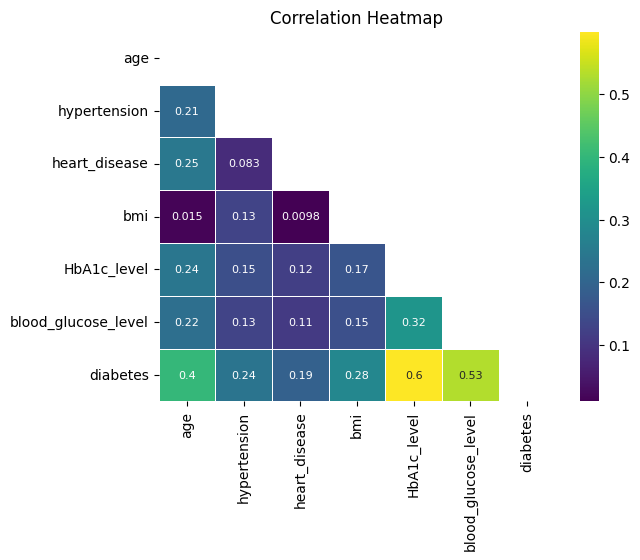

In [63]:
df_corr = df.select_dtypes(include='number').corr(method='pearson')


mask = np.zeros_like(df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_corr,annot=True,mask=mask,cmap='viridis',annot_kws={"size": 8},linewidths=0.5)
plt.ylim(df_corr.shape[1],0);
plt.title('Correlation Heatmap')
plt.show()


* The correlation heatmap shows the strength linear relationships between numerical variables in the dataset. Here are some key observations:

- HbA1c_level and blood_glucose_level have a higher positive correlation, which is expected since both measure blood sugar levels.
- Next age has a moderate positive correlation with diabetes.
- BMI and hypertension have a weak positive correlation with diabetes.
- Heart_disease has the least correlation with diabetes among the variables shown.


---

# Phase 2: Hypothesis-Driven EDA

Here we will formulate specific hypotheses based on initial obeservations and validate the hypotheses generated using statistical methods.
Below are the hypotheses we will be testing:

### 1) Association between HbA1c and Blood Glucose Levels with Diabetes

- **Null Hypothesis (H₀):**  
  There is **no association** between HbA1c levels and diabetes status; and no association between blood glucose levels and diabetes status.

- **Alternative Hypothesis (H₁):**  
  Higher HbA1c levels and blood glucose levels are **significantly associated** with an increased likelihood of diabetes.

### 2) Impact of Hypertension and Heart Disease on Diabetes

- **Null Hypothesis (H₀):**  
  There is **no association** between hypertension and diabetes status; and no association between heart disease and diabetes status.

- **Alternative Hypothesis (H₁):**  
  Individuals with hypertension and heart disease are **significantly more likely** to have diabetes.

### 3) Association between BMI and Diabetes

- **Null Hypothesis (H₀):**  
  BMI is **not associated** with diabetes status.

- **Alternative Hypothesis (H₁):**  
  Higher BMI is **significantly associated** with increased diabetes prevalence.

### 4) Association between Smoking and Diabetes

- **Null Hypothesis (H₀):**  
  Smoking status is **not associated** with diabetes status.

- **Alternative Hypothesis (H₁):**  
  Smokers have a **significantly higher chance** of having diabetes compared to non-smokers.

### 5) Association between Age and Diabetes

- **Null Hypothesis (H₀):**  
  Age is **not associated** with diabetes status.

- **Alternative Hypothesis (H₁):**  
  Older individuals have a **significantly higher prevalence** of diabetes.

* I plan to perform the following statistical tests to validate the hypotheses:

   - t-test : for continuous numeric variables (HbA1c_level, blood_glucose_level, BMI, age) against the binary target variable diabetes.
   - Chi-Squared test of independence: for categorical/binary variables (hypertension, heart_disease, gender, smoking_history) against the binary target variable diabetes.

#### we check the normality of the numeric variables

In [66]:
pg.normality(data=df, alpha=0.05)

c:\Users\nived\Desktop\Nivya work learnings\data analytics_ai\Capstone\Healthcare_Diabetes_Analysis\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9042.



W           pval  normal
age                  0.958428   7.351767e-45   False
hypertension         0.446506   1.926734e-97   False
heart_disease        0.333593  5.238272e-102   False
bmi                  0.886950   9.960851e-63   False
HbA1c_level          0.945664   2.433339e-49   False
blood_glucose_level  0.900595   2.941270e-60   False
diabetes             0.633406   1.088259e-87   False

* Since the variables distribution are not normal, I will use the non-parametric Mann-Whitney U test instead of t-test to compare the distributions of the numeric variables across the two diabetes groups.
* we will set a threshold of p-value < 0.05 to determine statistical significance.

### HYPOTHESIS TESTING

 * Since the continuous numeric variables will be validated using Mann-Whitney U test we will test the below hypotheses together:

    * Hypothesis 1: Association between HbA1c and Blood Glucose Levels with Diabetes  
    * Hypothesis 3: Association between BMI and Diabetes 
    * Hypothesis 5: Association between age and Diabetes

In [96]:

# List of continuous variables to perform the test on
variables = ['bmi', 'HbA1c_level', 'blood_glucose_level', 'age']

# Dictionary to store the 4 separate DataFrames
result_tables = {}

# Loop through each variable
for var in variables:
    group0 = df[df['diabetes'] == 0][var]
    group1 = df[df['diabetes'] == 1][var]

    # Mann-Whitney U Test
    stat, p = mannwhitneyu(group0, group1)

    # Create a DataFrame with summary stats as rows and groups(diabetes/no diabetes) as columns

    result_df = pd.DataFrame({
        'No Diabetes': [f"{group0.mean():.2f}",f"{group0.median():.2f}"],
        'Diabetes':    [f"{group1.mean():.2f}",f"{group1.median():.2f}"]
    }, index=['Mean', 'Median'])
    
    # Store the DataFrame in a dictionary using variable name as key
    result_tables[var] = result_df

    print(f'Result table for: {var}')
    print(result_tables[var])
    print(f'Mann-Whitney U statistic: {stat:.2f}, p-value: {p:.2e}')
    print('\n')



Result table for: bmi
       No Diabetes Diabetes
Mean         28.17    32.20
Median       27.32    30.10
Mann-Whitney U statistic: 6656112.00, p-value: 5.89e-176


Result table for: HbA1c_level
       No Diabetes Diabetes
Mean          5.39     6.95
Median        5.80     6.60
Mann-Whitney U statistic: 3214473.00, p-value: 0.00e+00


Result table for: blood_glucose_level
       No Diabetes Diabetes
Mean        132.71   194.35
Median      140.00   160.00
Mann-Whitney U statistic: 4334875.00, p-value: 0.00e+00


Result table for: age
       No Diabetes Diabetes
Mean         47.35    61.27
Median       47.00    62.00
Mann-Whitney U statistic: 5572761.50, p-value: 4.88e-298




### Observations and Inferences:
### * Hypothesis 1: Association between HbA1c and Blood Glucose Levels with Diabetes   

* For **HbA1c** - Mann-Whitney U statistic: 3214473.00, **p-value: 0.00e+00**
* For **Blood glucose level** - Mann-Whitney U statistic: 4334875.00, **p-value: 0.00e+00**
* Since the p-value in both the cases is 0 which is **< 0.05**, we **reject the null hypothesis-H₀** and conclude that there is a significant association between both HbA1c levels and blood glucose levels with diabetes status.
* The box plots from the descriptive EDA phase also support this conclusion.
* The correlation heatmap also showed a strong positive correlation between HbA1c and blood glucose levels with diabetes. 

* Statistics summary for HbA1c across diabetes groups:

| Statistic | No Diabetes | Diabetes |
|-----------|-------------|----------|
| Mean      | 5.39        | 6.95     |
| Median    | 5.80        | 6.60     |

* Statistics summary for blood_glucose_level across diabetes groups:

| Statistic | No Diabetes | Diabetes |
|-----------|-------------|----------|
| Mean      | 132.71      | 194.35   |
| Median    | 140.00      | 160.00   |


* From the stats above we can see that the mean(avg) and median(mid-point) values for both HbA1c and blood_glucose_level is higher n the diabetes group compared to the non-diabetes group.

**Conclusion:**
 * We can safely conclude that higher HbA1c levels and blood glucose levels are **significantly associated** with an increased likelihood of diabetes.

 ### * Hypothesis 3: Association between BMI and Diabetes 

* For **BMI** Mann-Whitney U statistic: 6656112.00, **p-value: 5.89e-176**
* Since the p-value is much **< 0.05**, we **reject the null hypothesis-H₀** and conclude that there is a significant association between BMI and diabetes status.
* the box plots from the descriptive EDA phase also support this conclusion.
* the correlation heatmap also showed a weak positive correlation between BMI and diabetes.

* Statistics summary for BMI across diabetes groups:

| Statistic | No Diabetes | Diabetes |
|-----------|-------------|----------|
| Mean      | 28.17       | 32.20    |
| Median    | 27.32       | 30.10    |

* From the stats above we can see the mean(avg) and median(mid-point) values of BMI is higher in the diabetes group compared to the non-diabetes group.

**Conclusion:**
 * We can safely conclude that **higher BMI levels** are **significantly associated** with an increased likelihood of diabetes.
### Hypothesis 5: Association between age and Diabetes

* For **age** Mann-Whitney U statistic: 5572761.50, **p-value: 4.88e-298**
* Since the p-value is much **< 0.05**, we **reject the null hypothesis-H₀** and conclude that there is a significant association between age and diabetes status.
* the box plots from the descriptive EDA phase also support this conclusion.
* the correlation heatmap also showed a moderate positive correlation between age and diabetes.

* Summary statistics for age across diabetes groups:

| Statistic | No Diabetes | Diabetes |
|-----------|-------------|----------|
| Mean      | 47.35       | 61.27    |
| Median    | 47.00       | 62.00    |

* From the stats above we can see the mean(avg) and median(mid-point) age in the diabetes group is higher compared to the non-diabetes group.

**Conclusion:**
 * We can safely conclude that **older age** is **significantly associated** with an increased likelihood of diabetes.

* Since the categorical/binary numeric variables will be validated using Chi-Squared test of independence we will test the below hypotheses together:

    * Hypothesis 2: Impact of Hypertension and Heart Disease on Diabetes
    * Hypothesis 4: Association between Smoking history and Diabetes


In [118]:

# grouping the smoking history
def bin_smoking(value):
    if value == 'never':
        return 'non-smoker'
    elif value in ['current', 'former', 'ever', 'not current']:
        return 'smoker'
    else:
        return 'unknown'

df['smoking_binned'] = df['smoking_history'].apply(bin_smoking)


# list of categorical/numeric binary variables to perform the test on

feature_cols = ['hypertension', 'heart_disease', 'gender', 'smoking_history','smoking_binned']
target_col = 'diabetes'  

for col in feature_cols:

    # # Create a contingency table
    # contingency_table = pd.crosstab(df[col], df[target_col])
    # print(f'Contingency Table for {col} vs {target_col}:\n{contingency_table}\n')

    # Run Chi-Square test
    expected, observed, stats = pg.chi2_independence(data=df, x=col, y=target_col)
    
    # accessing the stats from pearson test using [0] 
    chi2 = stats['chi2'].values[0]
    dof = stats['dof'].values[0]
    pval = stats['pval'].values[0]
    cramer = stats['cramer'].values[0]
    power = stats['power'].values[0]

     # Print the results

    print(f"{col} vs {target_col}")
    print(f"Chi2: {chi2:.4f} | DoF: {dof} | p-value: {pval:.6f} | Cramér's V: {cramer:.4f} | power: {power} \n")

hypertension vs diabetes
Chi2: 509.6341 | DoF: 1.0 | p-value: 0.000000 | Cramér's V: 0.2374 | power: 1.0 

heart_disease vs diabetes
Chi2: 328.5112 | DoF: 1.0 | p-value: 0.000000 | Cramér's V: 0.1906 | power: 1.0 

gender vs diabetes
Chi2: 81.6653 | DoF: 1.0 | p-value: 0.000000 | Cramér's V: 0.0950 | power: 0.9999999999992631 

smoking_history vs diabetes
Chi2: 312.7421 | DoF: 5.0 | p-value: 0.000000 | Cramér's V: 0.1860 | power: 1.0 

smoking_binned vs diabetes
Chi2: 261.3515 | DoF: 2.0 | p-value: 0.000000 | Cramér's V: 0.1700 | power: 1.0 



####  observations and Inferences:

* The statistical summary based on the Chi-Squared test of independence is as below:

| Feature         | Chi² Statistic | DoF | p-value  | Cramér's V | Power      | Strength of Association     |
|-----------------|----------------|-----|----------|------------|------------|-----------------------------|
| Hypertension    | 509.6341       | 1   | 0.000000 | 0.2374     | 1.0        | Moderate                    |
| Heart Disease   | 328.5112       | 1   | 0.000000 | 0.1906     | 1.0        | Weak to Moderate            |
| Gender          | 81.6653        | 1   | 0.000000 | 0.0950     | ~1.0       | Negligible to Weak          |
| Smoking History | 312.7421       | 5   | 0.000000 | 0.1860     | 1.0        | Weak to Moderate            |
| smoking_binned  | 261.3515       | 2   | 0.000000 | 0.1700     | 1.0        | weak to Moderate            |

* Power near 1.0 means the test is very likely to detect an effect if one exists (i.e. very low risk of Type II error).
* Cramer's V values indicate the strength of association: closer to 0 means weak association, closer to 1 means strong association.
* Strength of association is interpreted based on Cramer's V values.
* **p-value < 0.05** indicates we **reject the null hypothesis-H₀ for all features** and conclude there is an association between  the features hypertension, heart disease, gender, smoking history and target diabetes status. But the strength of association varies.

#### **Conclusion:**
**Hypertension**
* Only hypertension shows a moderate association with diabetes. The bar plots (proportions) from the descriptive EDA phase also support this conclusion.

**Heart Disease**
* Heart disease shows a weak to moderate association with diabetes. The bar plots (proportions) from the descriptive EDA phase also support this conclusion.

**Gender**
* Gender has the least association with diabetes. The bar plots (proportions) from the descriptive EDA phase also support this conclusion.

**Smoking History**
* Even with smoking history binned, the association strength is still weak to moderate. The bar plots(proportions) from the descriptive EDA phase also doesnt not show a strong association of any one smoking category with diabetes.

**Overall:**
* The correlation heatmap also showed weak positive correlation between hypertension, heart disease and diabetes.



---

**Final remarks and next steps:**
* Based on the EDA findings, we can conclude that several factors are significantly associated with diabetes status.    
    * Higher HbA1c levels, blood glucose levels, BMI, and older age are all strongly linked to an increased likelihood of diabetes. 
    * Additionally, hypertension shows moderate association with diabetes.
    * Gender, heart disease and smoking history exhibit weaker

* Next we proceed with feature engineering and selection, followed by model building and evaluation to predict diabetes status.

---